<a href="https://colab.research.google.com/github/Devika0101/CODING-SAMURAI-INTERNSHIP-TASK/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AAPL_data.csv to AAPL_data.csv


In [ ]:
# Upgrade pip
!pip install --upgrade pip

# Install mpi4py and required packages
!apt-get install -y mpich
!pip install mpi4py
!pip install pandas numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  hwloc-nox libmpich-dev libmpich12 libslurm37
Suggested packages:
  mpich-doc
The following NEW packages will be installed:
  hwloc-nox libmpich-dev libmpich12 libslurm37 mpich
0 upgraded, 5 newly installed, 0 to remove and 41 not upgraded.
Need to get 14.2 MB of archives.
After this operation, 102 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libslurm37 amd64 21.08.5-2ubuntu1 [542 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 hwloc-nox amd64 2.7.0-2ubuntu1 [205 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmpich12 amd64

In [ ]:
import pandas as pd

df = pd.read_csv("AAPL_data.csv")
print(df.head())
print(df.dtypes)


        Price              Close               High                Low  \
0      Ticker               AAPL               AAPL               AAPL   
1        Date                NaN                NaN                NaN   
2  2020-01-02  72.46825408935547  72.52857392672578  71.22325176244068   
3  2020-01-03  71.76372528076172  72.52375386627762  71.53933722124737   
4  2020-01-06   72.3355712890625   72.3741768820521  70.63455422652187   

                Open     Volume  
0               AAPL       AAPL  
1                NaN        NaN  
2  71.47659213409148  135480400  
3  71.69616734789946  146322800  
4  70.88548689932232  118387200  
Price     object
Close     object
High      object
Low       object
Open      object
Volume    object
dtype: object


In [ ]:
# monte_carlo_hybrid_colab.py
import pandas as pd
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import time
import importlib

In [ ]:
# Step 1: Check if MPI is available
mpi_available = importlib.util.find_spec("mpi4py") is not None
if mpi_available:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
else:
    comm = None
    rank = 0
    size = 1


In [ ]:
# Step 2: Load dataset (only rank 0)
if rank == 0:
    df = pd.read_csv("AAPL_data.csv")
    if 'Adj Close' in df.columns:
        prices = df['Adj Close']
    else:
        prices = df['Close']

    # Ensure chronological order
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.sort_values('Date')
        prices = prices.loc[df.index]

    # Clean prices: remove commas, dollar signs, convert to numeric
    prices = pd.to_numeric(prices.astype(str).str.replace(',', '').str.replace('$', ''), errors='coerce')
    prices = prices.dropna()  # drop invalid rows

    # Calculate log returns
    log_returns = np.log(prices / prices.shift(1)).dropna()
    mu = log_returns.mean()
    sigma = log_returns.std()
    S0 = prices.iloc[-1]
else:
    mu = sigma = S0 = None

In [ ]:
# Step 3: Broadcast parameters if MPI is used
if mpi_available:
    mu = comm.bcast(mu, root=0)
    sigma = comm.bcast(sigma, root=0)
    S0 = comm.bcast(S0, root=0)

In [ ]:
# Step 4: Simulation function
def simulate_chunk(args):
    S0, mu, sigma, horizon, n_sims, seed = args
    np.random.seed(seed)
    Z = np.random.standard_normal(n_sims)
    drift = (mu - 0.5 * sigma**2) * horizon
    vol = sigma * np.sqrt(horizon)
    ST = S0 * np.exp(drift + vol * Z)
    losses = -(ST - S0) / S0
    return losses

In [ ]:
# Step 5: Monte Carlo parameters
horizon = 252         # 1 year
total_sims = 200000   # number of Monte Carlo paths
confidence = 0.99     # 99% VaR
workers = mp.cpu_count()

In [ ]:
# Step 6: Distribute simulations across processes
chunk_size = total_sims // size
start_time = time.time()

if mpi_available:
    # MPI parallel version
    seed = rank + 123
    losses_local = simulate_chunk((S0, mu, sigma, horizon, chunk_size, seed))
    all_losses = comm.gather(losses_local, root=0)
    if rank == 0:
        losses = np.concatenate(all_losses)
        duration = time.time() - start_time
        print(f"Simulation completed using MPI with {size} processes in {duration:.2f} sec")
else:
    # Multiprocessing fallback version
    args_list = [(S0, mu, sigma, horizon, total_sims // workers, i + 1) for i in range(workers)]
    with mp.Pool(processes=workers) as pool:
        results = pool.map(simulate_chunk, args_list)
    losses = np.concatenate(results)
    duration = time.time() - start_time
    print(f"Simulation completed using multiprocessing ({workers} cores) in {duration:.2f} sec")

Simulation completed using MPI with 1 processes in 0.01 sec



--- Monte Carlo Financial Risk Results ---
Total simulations: 200000
Value at Risk (99%) = -150.72%
Expected Shortfall (99%) = -24.18%


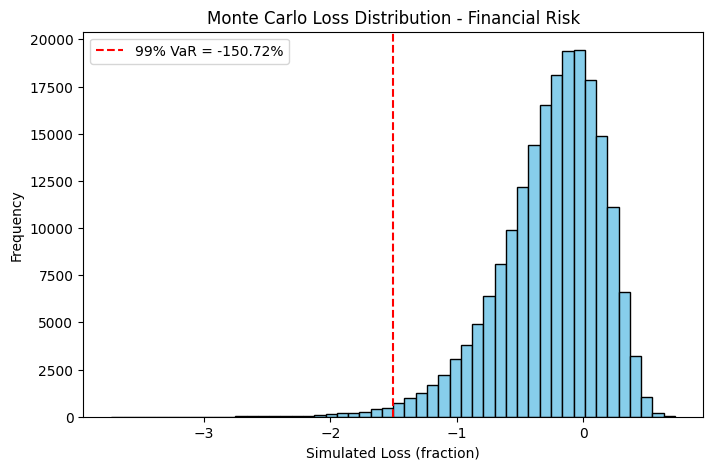

In [ ]:
# Step 7: Risk metrics (only rank 0 prints)
if rank == 0:
    sorted_losses = np.sort(losses)[::-1]
    pos = int(np.ceil(confidence * len(sorted_losses))) - 1
    VaR = sorted_losses[pos]
    ES = sorted_losses[:pos + 1].mean()
    print("\n--- Monte Carlo Financial Risk Results ---")
    print(f"Total simulations: {len(losses)}")
    print(f"Value at Risk (99%) = {VaR*100:.2f}%")
    print(f"Expected Shortfall (99%) = {ES*100:.2f}%")

    # Plot loss distribution
    plt.figure(figsize=(8,5))
    plt.hist(losses, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(VaR, color='red', linestyle='--', label=f'99% VaR = {VaR:.2%}')
    plt.xlabel("Simulated Loss (fraction)")
    plt.ylabel("Frequency")
    plt.title("Monte Carlo Loss Distribution - Financial Risk")
    plt.legend()
    plt.show()